In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score,confusion_matrix, accuracy_score
import tensorboard
import datetime
from tensorflow.keras import models
from PIL import Image
import requests
import io
import tensorflow_hub as hub
import warnings
import tensorflow_addons as tfa
import time
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('INFO')

In [28]:
path = r"C:\Users\Admin\Desktop\Tensorboard_logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

In [29]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [30]:
f1 = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average = 'macro')

In [31]:
IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_dataset = image_generator.flow_from_directory(r'C:\Users\Admin\Desktop\fire\data\Dataset\Vali',target_size=IMAGE_SHAPE)
image_data = image_generator.flow_from_directory(r'C:\Users\Admin\Desktop\fire\data\Dataset\Train',target_size=IMAGE_SHAPE)

Found 380 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.


In [32]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [33]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [34]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
feature_extractor_layer.trainable = False

(32, 1280)


In [35]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
predictions = model(image_batch)

In [38]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy', f1])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 48 steps, validate for 12 steps
Epoch 1/10
48/48 [==============================] - 39s 815ms/step - loss: 0.2904 - accuracy: 0.8740 - f1_score: 0.8648 - val_loss: 0.1285 - val_accuracy: 0.9658 - val_f1_score: 0.9650
Epoch 2/10
48/48 [==============================] - 46s 954ms/step - loss: 0.0686 - accuracy: 0.9891 - f1_score: 0.9890 - val_loss: 0.0852 - val_accuracy: 0.9776 - val_f1_score: 0.9773
Epoch 3/10
48/48 [==============================] - 74s 2s/step - loss: 0.0435 - accuracy: 0.9941 - f1_score: 0.9941 - val_loss: 0.0697 - val_accuracy: 0.9829 - val_f1_score: 0.9827
Epoch 4/10
48/48 [==============================] - 73s 2s/step - loss: 0.0326 - accuracy: 0.9970 - f1_score: 0.9970 - val_loss: 0.0637 - val_accuracy: 0.9842 - val_f1_score: 0.9840
Epoch 5/10
48/48 [==============================] - 72s 2s/step - loss: 0.0261 - accuracy: 0.9974 - f1_score: 0.9974 - val_loss: 0.0584 - val_accuracy: 0.9842 - val_f1_score: 0.9840
Epoch 6/10
48/48 [========================

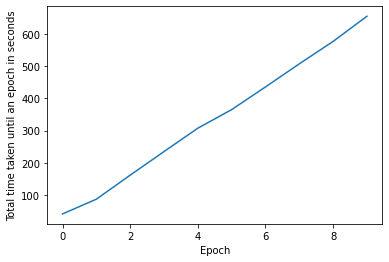

In [39]:
save_best_model = SaveBestModel()
model.fit(image_data, epochs=10,validation_data=validation_dataset,callbacks=[tensorboard_callback,timecallback(),save_best_model])
model.set_weights(save_best_model.best_weights)

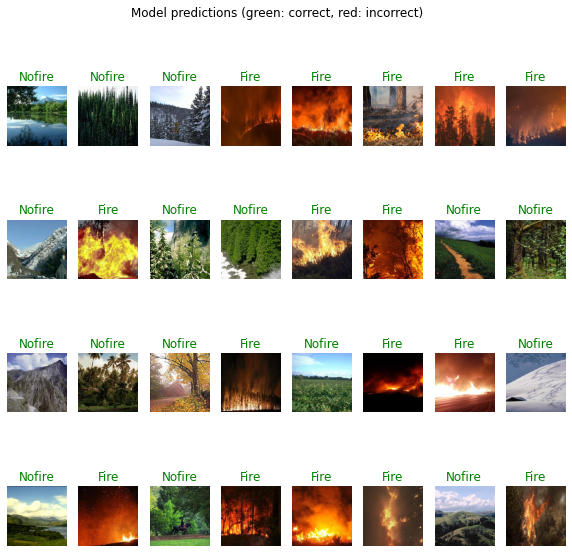

In [40]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(4,8,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

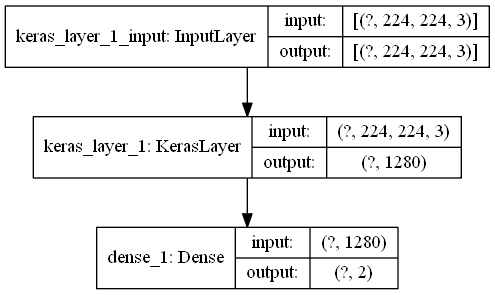

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv_base.png')

In [42]:
forests = [
'http://meteo.camera/mavroudi/?',
'http://www.livecamera.gr/webcam4/tinos4.jpg',
'http://www.northmeteo.gr/cam/astypalea/webcam.jpg?',
'https://www.cityofxanthi.gr/images/videos/xanthi1.jpg',
'http://www.stravon.gr/meteocams/aridaia/',
'https://www.livecameras.gr/thumbs/temp/ithak2.jpg',
'https://www.terracom.gr/sites/default/files/pictures/cam_01/cam05.jpg?',
'https://www.livecameras.gr/thumbs/temp/ithak2.jpg',
'http://www.zakynthos.at/zantecam/webcam.jpg',
'http://weather-messinia.gr/cams/paralia2.jpg',
'https://www.kopaida.gr/cams/antcam1.jpg'
]

In [43]:
from PIL import Image
fire,nonfire = 0,0
fire_photo =[]
for i in forests:
    try:
        x = Image.open(requests.get(i, stream=True).raw)
        X = x.resize((224,224),Image.ANTIALIAS)
        X = image.img_to_array(X)
        X = np.expand_dims(X,axis=0)
        val = model.predict(X)
        predicted_id = np.argmax(val, axis=-1)
        predicted_label_batch = class_names[predicted_id]
        if predicted_label_batch=='fire':
            fire+=1
            fire_photo.append(x)
            print('fire detected, please visit', i )
        else:
            nonfire+=1
            nofirephoto = i
            print('no fire detected')

    except:
        pass
print('total fires:', fire, ' of ', len(forests))
print('no fires:', nonfire, ' of ', len(forests))
print('could not connect to:', len(forests)-fire-nonfire)

no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
total fires: 0  of  11
no fires: 10  of  11
could not connect to: 1


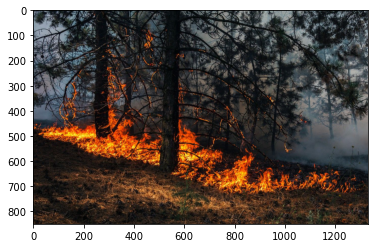

In [44]:
x = Image.open(requests.get(nofirephoto, stream=True).raw)
flame = Image.open(requests.get('https://wallpaperaccess.com/full/1817829.jpg', stream=True).raw)
plt.imshow(flame)

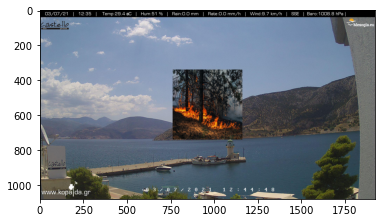

In [45]:
from PIL import Image
flame = flame.resize((400,400),Image.ANTIALIAS)
img_w, img_h = flame.size
bg_w, bg_h = x.size
offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
x.paste(flame, offset)
plt.imshow(x)

fire detected


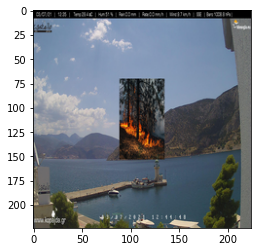

In [46]:
from PIL import Image
x = x.resize((224,224),Image.ANTIALIAS)
X = image.img_to_array(x)
X = np.expand_dims(X,axis=0)
augmented_test = model.predict(X)
if augmented_test[0][0]>augmented_test[0][1]:
    print('fire detected')
else:
    print('no fire detected')
    
#print(augmented_test)
plt.imshow(x)

In [47]:
model.save(r'C:\Users\Admin\Desktop\my_supermodel',save_format='tf')

INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\my_supermodel\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\my_supermodel\assets


In [48]:
f1 = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average = 'macro')
new_model = tf.keras.models.load_model(r'C:\Users\Admin\Desktop\my_supermodel', custom_objects={"f1": f1}, compile=False)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
